# Pipeline exploration
If you ended up here and don't understand what It's being done go to the README file of the repository.

In this notebook I'll explore how to better use the dataframes and the Pipeline from sklearn to do the script that will do the full comparison.

In [1]:
# Importing main libraries
import matplotlib
import h5py
import pickle
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import nexusformat.nexus as nx
from benchtools.src.clustering import build_features
from benchtools.src.datatools import separate_data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Importing the classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans

# Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

## Getting the data

I'll pre-process the data using the <code>benchtools</code> package. The next cell just need to be ran one time

In [2]:
build_features(path_data='..\..\events_anomalydetection.h5', nbatch=10, outname='RD_dataset')

A file with that name already exists


In [3]:
# Importing the data 
df = pd.read_csv("..\data\RD_dataset.csv")
df.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,m_jj,deltaR_j12,n_hadrons,label
0,1286.727685,106.912129,0.185508,-2.763676,1313.290435,0.624659,36,1283.220733,63.164215,0.064989,0.393688,1287.481934,0.713248,33,2580.489568,3.159663,109.0,0.0
1,1354.394070,614.269108,0.826505,1.365524,1943.559886,0.311688,84,1325.613761,439.064150,-0.874319,-1.786248,1916.370744,0.276881,97,3859.315047,3.581406,208.0,0.0
2,1214.955723,645.865619,-0.196786,2.040545,1396.840654,0.238205,119,1072.462085,113.768840,0.143831,-1.090330,1089.530630,0.726963,59,2480.769725,3.149348,196.0,0.0
3,1285.227873,516.835248,0.328693,2.975321,1450.485926,0.013429,65,1220.251279,174.796077,0.294854,-0.322661,1285.618789,0.706361,89,2609.893413,3.298155,183.0,0.0
4,1210.415787,129.499352,-0.744836,-2.883347,1567.345300,0.423550,54,1091.785816,155.362262,1.060534,0.264977,1772.340209,0.787662,57,3313.488835,3.629229,169.0,1.0


Since this is not the complete comparison I'll use a smaller dataset to avoid running with memory issues. Also, I'll eliminate the columns of mass to make the training as model-free as possible

In [4]:
df_RD = df.sample(100000, random_state = 1).drop(['m_j1', 'm_j2', 'm_jj'], axis=1)
df_RD.head()

,pT_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,deltaR_j12,n_hadrons,label
264511,1636.540865,0.224496,-2.373993,1729.163350,0.371356,118,1547.619954,1.162014,0.710714,2722.719214,0.377317,59,3.224028,228.0,0.0
446040,1700.570450,-1.046567,-0.074009,2722.693611,0.173263,20,1471.042986,-0.496909,-3.102066,1660.217227,0.931903,39,3.077540,89.0,1.0
367350,1209.240264,1.501579,3.008941,2849.555797,0.693441,20,1192.250774,1.114281,-0.051151,2015.636945,0.527644,33,3.084503,86.0,0.0
510497,1331.228201,0.991312,2.934796,2041.150095,0.746076,13,1206.745736,0.501046,-0.197147,1366.214578,0.967665,54,3.170083,122.0,0.0
301480,1229.918669,-0.947064,2.870159,1828.159257,0.918211,39,1226.020830,0.063516,-0.261698,1238.924198,0.873326,42,3.290866,109.0,0.0


## Defining functions and global variables
First I'll define the list of pre-selected algorithms based on the results of notebook 4, 8 and 13

In [5]:
# Listing the classifiers to compare
classifiers = [RandomForestClassifier(),
                GradientBoostingClassifier(),
                QuadraticDiscriminantAnalysis(), 
                MLPClassifier(),
                KMeans(n_clusters=2, random_state=15)]

The algorithms need the training features and the labels separated

In [6]:
# Separating the features from the label
X, y = separate_data(df_RD, standarize=False)

Lastly, a function that trains the algorithms with the <code>Pipeline</code> function of sklearn and use it to get the predicted labels and scores for each algorithm

In [7]:
def supervised_pipeline(X, y, classifiers, dimension_reduction=None):
    # Get the training and testing samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
    
    # To save the output
    names = []
    scores = []
    preds = []
    
    for clf in tqdm(classifiers):
        name = clf.__class__.__name__

        # Simple pipeline
        model = Pipeline(steps=[('ss', StandardScaler()), ('clf', clf)])

        # Training the model
        try: model.fit(X_train, y_train)
            
        except: model.fit(X_train) # For KMeans which is unsupervised
        
        # Probability or distances
        try: 
            y_score = model.predict_proba(X_test)
            scores.append(y_score[:,1])
        except: 
            # KMeans doesn't have a probability, so here we get 
            # the distances to each cluster
            y_score = model.transform(X_test)
            # The score for KMeans is defined differently
            norm = np.linalg.norm(y_score[:,1])
            scores.append(1-y_score[:,1]/norm)
            
        # Gettin the prediction
        y_pred = model.predict(X_test)
        
        # Saving name and predictions
        names.append(name)
        preds.append(y_pred)

    return names, scores, preds, y_test

## Training the algorithms and comparing
First, we use the function to train the algorithms and get the scores and predictions

In [8]:
names, scores, preds, y_test = supervised_pipeline(X, y, classifiers)

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


And check that the data is saved as expected: a dictionary were each key is the name of the algorithm and for each key an array with the scores or predictions

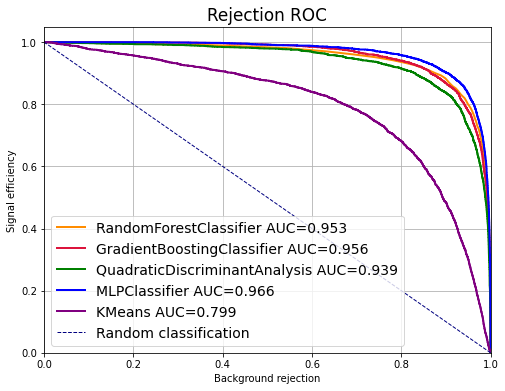

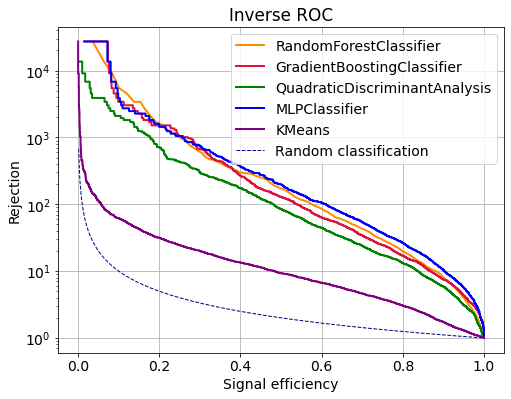

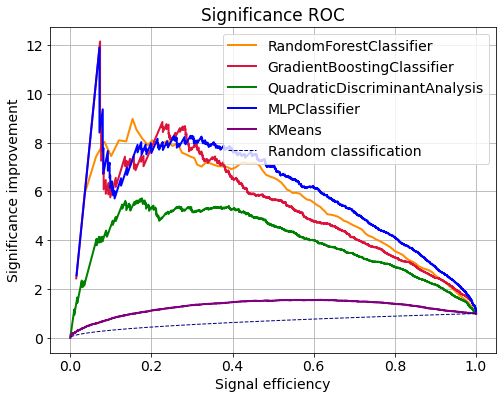

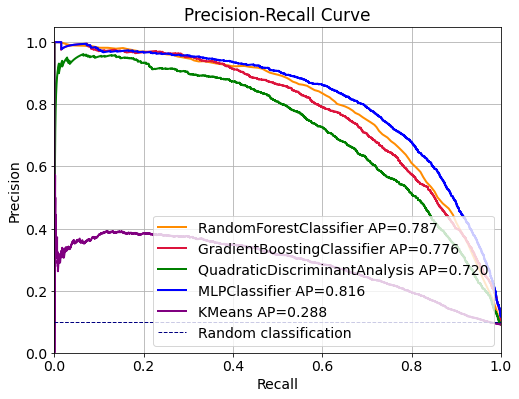

In [9]:
from benchtools.src.metrictools import performance_metrics, rejection_plot, inverse_roc_plot, significance_plot, precision_recall_plot

rejection_plot(names=names, labels=y_test, probs=scores)
plt.show()

inverse_roc_plot(names=names, labels=y_test, probs=scores)
plt.show()

significance_plot(names=names, labels=y_test, probs=scores)
plt.show()

precision_recall_plot(names=names, labels=y_test, probs=scores)
plt.show()

Here is easy to add any set of name/score/pred for any other classifier

In [10]:
# I'll add a list for the labels because currently they won't be the same
labels = [y_test, y_test, y_test, y_test, y_test,]

In [11]:
# UCluster (for more information, check notebook 10)
names.append('UCluster')
y_score = np.array(h5py.File('..\data\\rd_dist_full.h5', 'r')['distances'])
norm = np.linalg.norm(y_score[:,1])
scores.append(1-y_score[:,1]/norm)
preds.append(np.array(h5py.File('..\data\\rd_dist_full.h5', 'r')['pid']))
labels.append(np.array(h5py.File('..\data\\rd_dist_full.h5', 'r')['label']))

In [12]:
# GAN-AE (for more information check notebook 11)
names.append('GAN-AE')

# This needs to be cleaner
# Reading the distances
dist_bkg = pd.DataFrame(np.array(h5py.File('..\data\RnD_distances.h5', 'r')['bkg']), columns=['y_score'])
dist_sig = pd.DataFrame(np.array(h5py.File('..\data\RnD_distances.h5', 'r')['sig1']), columns=['y_score'])

# Adding labels, 0 for background and 1 for signal
dist_bkg['label']=0
dist_sig['label']=1

# Getting together each signal with the background
df_sig = pd.concat([dist_bkg, dist_sig])

label = np.array(df_sig.loc[:,'label'])
score = np.array(df_sig.loc[:,'y_score'])

from benchtools.src.metrictools import optimal_threshold

threshold = optimal_threshold(label, score)
df_sig['y_pred']=(df_sig['y_score'] >= threshold).astype(float)

pred = df_sig.loc[:,'y_pred']


scores.append(score)
preds.append(pred)
labels.append(label)

First I'll check that the lenght of the scores, predictions and labels for each algorithm matches and then plot the metrics

In [13]:
for name, score, label, pred in zip(names,scores,labels,preds):
    print(name, score.shape, label.shape, pred.shape)

RandomForestClassifier (30000,) (30000,) (30000,)
GradientBoostingClassifier (30000,) (30000,) (30000,)
QuadraticDiscriminantAnalysis (30000,) (30000,) (30000,)
MLPClassifier (30000,) (30000,) (30000,)
KMeans (30000,) (30000,) (30000,)
UCluster (3072,) (3072,) (3072,)
GAN-AE (198494,) (198494,) (198494,)


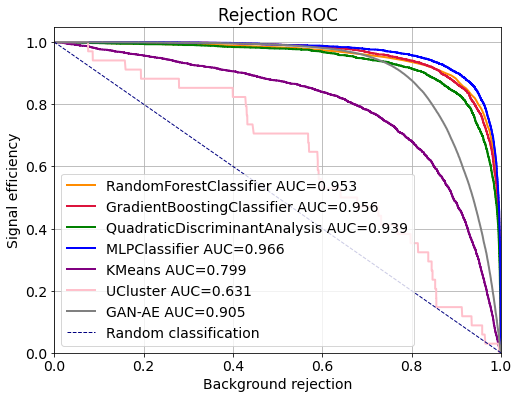

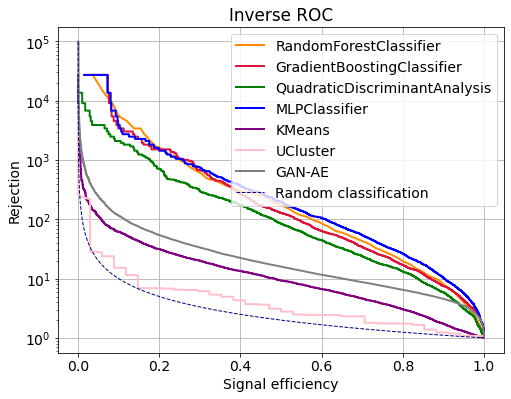

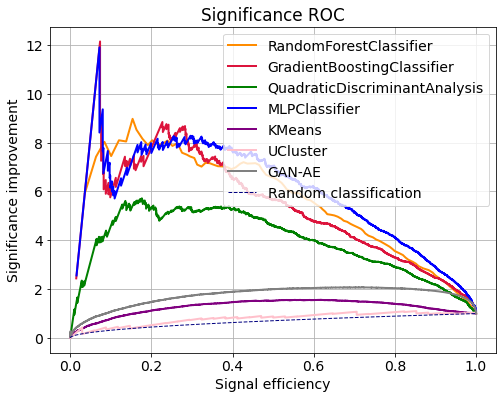

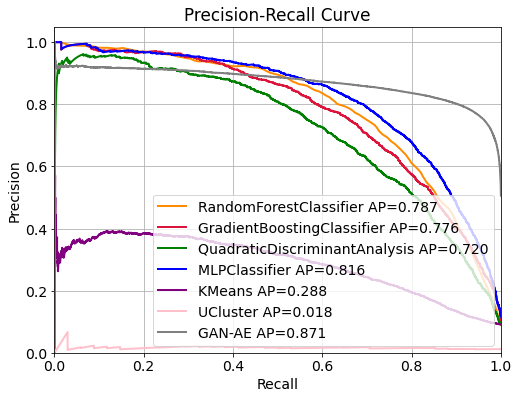

In [14]:
rejection_plot(names=names, labels=labels, probs=scores)
plt.show()

inverse_roc_plot(names=names, labels=labels, probs=scores)
plt.show()

significance_plot(names=names, labels=labels, probs=scores)
plt.show()

precision_recall_plot(names=names, labels=labels, probs=scores)
plt.show()

## Trying with classes

Maybe doing 'classifier' and 'multiple_clf' classes makes it easy

In [15]:
class classifier:
    def __init__(self, name, score, pred, label):
        self.name = name
        self.score = score
        self.pred = pred       
        self.label = label
    #def numeric_metrics()
        
    def rejection(self):
        rejection_plot(self.name, self.label, self.score)
        plt.show()
        
    def inverse_roc(self):
        inverse_roc_plot(self.name, self.label, self.score)
        plt.show()
    
    def significance(self):
        significance_plot(self.name, self.label, self.score)
        plt.show()
        
    def precision_recall(self):
        precision_recall_plot(self.name, self.label, self.score)
        plt.show()

In [16]:
rfc = classifier(names[0], scores[0], preds[0], labels[0])

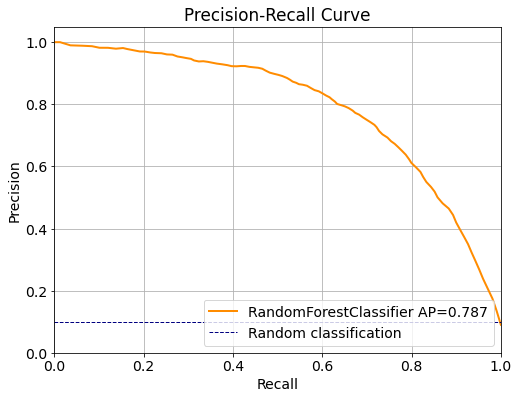

In [17]:
rfc.precision_recall()

In [18]:
class multiple_classifiers:
    def __init__(self):
        self.clfs = []
        self.names = []
    
    def add_classifier(self, classifier):
        self.clfs.append(classifier)
        self.names.append(classifier.name)
        
    #def compare_numeric_metrics():
    
    def extract_lists(self):
        names = [clf.name for clf in self.clfs]
        scores = [clf.score for clf in self.clfs]
        preds = [clf.pred for clf in self.clfs]      
        labels = [clf.label for clf in self.clfs] 
        return names, labels, scores, preds
        
    def compare_rejection(self):
        names, labels, scores, _ = self.extract_lists(self)
        rejection_plot(names, labels, scores)
        plt.show()
    
    def compare_inverse_roc(self):
        names, labels, scores, _ = self.extract_lists()
        inverse_roc_plot(names, labels, scores)
        plt.show()
    
    def compare_significance(self):
        names, labels, scores, _ = self.extract_lists()
        significance_plot(names, labels, scores)
        plt.show()
        
    def compare_precision_recall(self):
        names, labels, scores, _ = self.extract_lists()
        precision_recall_plot(names, labels, scores)
        plt.show()

We can use <code>pickle</code> to save the list of classifiers

In [19]:
# saving it as a pickle file
multiclf_list = []

for name, score, label, pred in zip(names,scores,labels,preds):
    multiclf_list.append(classifier(name, score, pred, label))

print(multiclf_list[0].name)

with open("pipeline_test", "wb") as fp:   #Pickling
    pickle.dump(multiclf_list, fp)

RandomForestClassifier


In [20]:
with open("pipeline_test", "rb") as fp:   # Unpickling
    new_list = pickle.load(fp)

new_list[0].name

'RandomForestClassifier'

We can also use the compare class

In [21]:
multi_clf = multiple_classifiers()

for name, score, label, pred in zip(names,scores,labels,preds):
    multi_clf.add_classifier(classifier(name, score, pred, label))

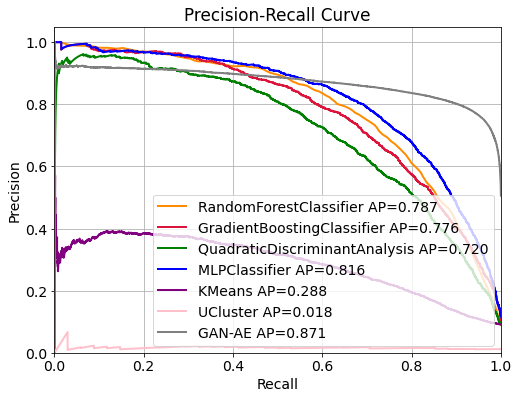

In [22]:
multi_clf.compare_precision_recall()

The plots could be a same method with an option for each plot

In [23]:
class multiple_classifiers_2:
    def __init__(self):
        self.clfs = []
        self.names = []
    
    def add_classifier(self, classifier):
        self.clfs.append(classifier)
        self.names.append(classifier.name)
        
    #def compare_numeric_metrics():
    
    def extract_lists(self):
        names = [clf.name for clf in self.clfs]
        scores = [clf.score for clf in self.clfs]
        preds = [clf.pred for clf in self.clfs]      
        labels = [clf.label for clf in self.clfs] 
        return names, labels, scores, preds
        
    def compare_plots(self, plot_type):
        names, labels, scores, _ = self.extract_lists()
        
        options = {'rejection': rejection_plot,
                  'inverse_roc': inverse_roc_plot,
                  'significance': significance_plot,
                  'precision_recall': precision_recall_plot}
        
        ax = options[plot_type](names, labels, scores)
        plt.show()

In [24]:
multi_clf_2 = multiple_classifiers_2()

for name, score, label, pred in zip(names,scores,labels,preds):
    multi_clf_2.add_classifier(classifier(name, score, pred, label))

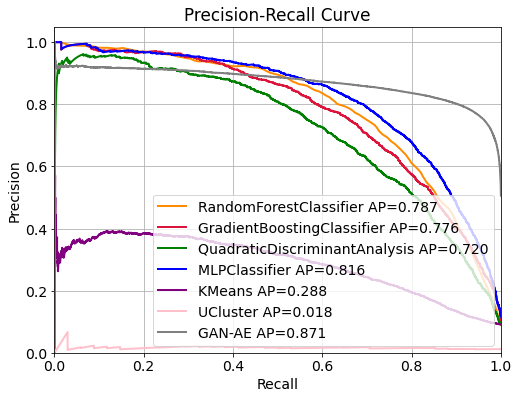

In [25]:
multi_clf_2.compare_plots('precision_recall')

The 'classifier' class could be useful to save the classifiers. I think that a class for comparing won't be necessary.